In [1]:
##########################
## implement a3 in squin ##
##########################
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit
from bloqade.cirq_utils import noise, parallelize, remove_tags
from cirq.contrib.svg import SVGCircuit,circuit_to_svg
import bloqade.stim
import bloqade.tsim
import numpy as np
from math import pi
from typing import Literal


@squin.kernel
def magicstateprep(q: ilist.IList[Qubit, Literal[7]]):
    #squin.h(qubits[ind])
    squin.t(q[2])


def mapping_f(n):
    dicti = {0:1, 1:3, 2:7, 3:6, 4:2, 5:5, 6:4}


'''@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.reset(q[0:6])
    #squin.h(q[6])
    for i in range(6):
        squin.ry(-pi / 2, q[i])
    squin.cz(q[1], q[2])
    squin.cz(q[3], q[4])
    squin.cz(q[5], q[6])
    squin.ry(pi / 2, q[6])
    squin.cz(q[0], q[3])
    squin.cz(q[2], q[5])
    squin.cz(q[4], q[6])
    for i in range(2, 7):
        squin.ry(pi / 2, q[i])
    for i in range(0, 5, 2):
        squin.cz(q[i], q[i + 1])
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[2])
    squin.ry(pi / 2, q[4])

    squin.cx(q[0],q[2])
    squin.cx(q[2],q[0])
    squin.cx(q[0],q[2])

    squin.cx(q[2],q[6])
    squin.cx(q[6],q[2])
    squin.cx(q[2],q[6])

    squin.cx(q[3],q[6])
    squin.cx(q[6],q[3])
    squin.cx(q[3],q[6])

    squin.z(q[3])
    squin.x(q[6])'''

@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    #for i in range(2):
    #    squin.reset(q[i])
    #for i in range(3, 7):
    #    squin.reset(q[i])
    magicstateprep(q)
    # ry(-pi/2) on old 0..5  ->  new [3,1,0,6,4,5]
    for j in (3, 1, 0, 6, 4, 5):
        squin.ry(-pi / 2, q[j])

    # cz(1,2), cz(3,4), cz(5,6) -> cz(1,0), cz(6,4), cz(5,2)
    squin.cz(q[1], q[0])
    squin.cz(q[6], q[4])
    squin.cz(q[5], q[2])

    # ry on old 6 -> new 2
    squin.ry(pi / 2, q[2])

    # cz(0,3), cz(2,5), cz(4,6) -> cz(3,6), cz(0,5), cz(4,2)
    squin.cz(q[3], q[6])
    squin.cz(q[0], q[5])
    squin.cz(q[4], q[2])

    # ry on old 2..6 -> new [0,6,4,5,2]
    for j in (0, 6, 4, 5, 2):
        squin.ry(pi / 2, q[j])

    # cz(0,1), cz(2,3), cz(4,5) -> cz(3,1), cz(0,6), cz(4,5)
    squin.cz(q[3], q[1])
    squin.cz(q[0], q[6])
    squin.cz(q[4], q[5])

    # final single-qubit ry: old 1 -> 1, old 2 -> 0, old 4 -> 4
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[0])
    squin.ry(pi / 2, q[4])
    squin.z(q[3])
    squin.x(q[0])
    squin.x(q[1])
    squin.x(q[3])



@squin.kernel
def main():
    q = squin.qalloc(7)
    injection(q)
    
circ = emit_circuit(main)
circ_load = load_circuit(circ)
circ_stim = bloqade.tsim.Circuit(circ_load)
graph = circ_stim.diagram(type="timeline-svg")


# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding Functions
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)
    
    #steane_encode_zero_on(q[0:7])
    injection(q[0:7])
    # Qubits 0-6: logical data
    # Qubits 8-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i+7])

    # Reset ancilla qubits 8-14
    #for i in range(8, 15):
    #    squin.reset(q[i])
    
    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i+14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i+14])
    
    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

graph

In [4]:
#%pip install cairosvg
# Save circuit diagram to PNG
# First save SVG, then convert to PNG using cairosvg
svg_content = graph.data if hasattr(graph, 'data') else str(graph)

# Save as SVG first
with open("a3_circuit.svg", "w", encoding="utf-8") as f:
    f.write(svg_content)

# Convert to PNG using cairosvg
try:
    import cairosvg
    cairosvg.svg2png(bytestring=svg_content.encode('utf-8'), write_to="a3_circuit.png", scale=2)
    print("✓ Saved: a3_circuit.png")
except ImportError:
    print("cairosvg not installed. Run: pip install cairosvg")
    print("SVG saved to: a3_circuit.svg")

OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.so.2'
cannot load library 'libcairo.2.dylib': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.2.dylib'
cannot load library 'libcairo-2.dll': error 0x7e.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo-2.dll'

In [25]:

# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []

# Noise channel
noise_model = noise.GeminiTwoZoneNoiseModel(scaling_factor=1)

for i in range(loops):
    # Generate circuit
    cirq_enc = emit_circuit(a3_circuit)
    # Parallelize a circuit
    parallel_circuit = parallelize(cirq_enc)
    # Remove internal tags (for cleaner visualization)
    parallel_circuit = remove_tags(parallel_circuit)
    #svg_text = SVGCircuit(parallel_circuit)._repr_svg_()

    #with open("circuit.svg", "w", encoding="utf-8") as f:
    #    f.write(svg_text)
    print("I am before the transform")
    # Apply noise to this circuit
    noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
    print("I am at this stage")
    # Convert to stim circuit and sample
    squin_enc = load_circuit(noisy_cirq_enc)
    stim_enc = bloqade.tsim.Circuit(squin_enc)
    sampler = stim_enc.compile_sampler()
    print("I am at that stage")
    # Sample this noisy circuit
    samples = sampler.sample(shots=shots_per_loop)
    all_samples.extend(samples)

samples_enc = np.array(all_samples)

# Show diagram from last circuit

print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print(f"Total samples collected: {len(samples_enc)} ({loops} loops × {shots_per_loop} shots)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(f"Error rate: {np.count_nonzero(samples_enc)/len(samples_enc):.4f}")



I am before the transform


KeyboardInterrupt: 

In [ ]:

synd_dict = {1:[1,3,5,7],2:[4,5,6,7],3:[2,3,6,7]}

In [ ]:
def to_parity(li):
    li_new = [-2*el+1 for el in li]
    return li_new

li = [False, True, False]

In [ ]:
def find_syndrome(li, idx):
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind-1]
    return True if mult == 1 else False


In [ ]:
def findZSyndrome(sample,idx):
    sample_z = sample[0:7]
    return find_syndrome(sample_z,idx)

def findXSyndrome(sample,idx):
    sample_x = sample[7:14]
    return find_syndrome(sample_x,idx)

In [ ]:
def compute_syndromes(sample,ind_dict):
    x_synds = []
    z_synds = []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample,idx))
        z_synds.append(findZSyndrome(sample,idx))
    return x_synds,z_synds

In [ ]:
def find_good_rate(samples,ind_dict):
    tot_samples = len(samples)
    good_samples = 0
    for j,sample in enumerate(samples):
        synd = compute_syndromes(sample,ind_dict)
        print(synd)
        will_add = 1 if np.count_nonzero(synd) == 6 else 0
        good_samples+=will_add
    return (good_samples)/len(samples)

In [ ]:
print(find_good_rate(samples_enc,synd_dict))

([False, False, True], [False, True, True])
([True, False, True], [True, False, True])
([False, False, True], [True, True, True])
([True, True, True], [False, False, False])
([False, False, True], [True, False, False])
([False, True, True], [True, False, True])
([True, False, True], [False, True, False])
([True, False, False], [False, True, True])
([True, False, True], [False, False, True])
([False, True, True], [True, False, False])
([True, True, False], [True, True, False])
([True, True, True], [False, True, True])
([False, True, True], [True, False, True])
([True, True, False], [False, True, True])
([True, False, True], [True, True, False])
([True, True, True], [False, True, False])
([True, False, True], [True, True, True])
([False, False, False], [False, False, True])
([False, False, True], [True, True, True])
([False, False, True], [False, False, True])
([True, True, False], [True, False, True])
([False, False, False], [True, False, True])
([True, False, False], [False, False, Fal

([True, True, True], [False, True, False])
([False, True, False], [True, True, True])
([False, True, True], [True, True, True])
([True, True, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [False, True, False])
([True, False, True], [False, False, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, False, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, True, True])
([False, True, False], [True, False, False])
([True, False, False], [False, True, True])
([False, True, False], [True, True, True])
([False, True, True], [True, True, True])
([True, True, True], [True, True, True])
([True, False, False], [True, True, True])
([True, True, True], [True, True, True])
([True, False, False], [True, True, True])
([True, True, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, True], [True, T

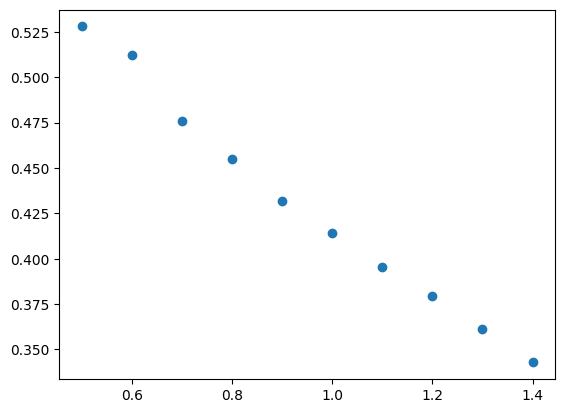

In [ ]:

import matplotlib.pyplot as plt
# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []
fidelities = []

coeffs = np.arange(0.5,1.5,0.1)

for coeff in coeffs:
    # Noise channel
    noise_model = noise.GeminiTwoZoneNoiseModel(scaling_factor=coeff)

    for i in range(loops):
        # Generate circuit
        cirq_enc = emit_circuit(a3_circuit)
        
        # Apply noise to this circuit
        noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
        
        # Convert to stim circuit and sample
        squin_enc = load_circuit(noisy_cirq_enc)
        stim_enc = bloqade.stim.Circuit(squin_enc)
        sampler = stim_enc.compile_sampler()
        
        # Sample this noisy circuit
        samples = sampler.sample(shots=shots_per_loop)
        all_samples.extend(samples)

    samples_enc = np.array(all_samples)
    fidelities.append(find_good_rate(samples_enc,synd_dict))

plt.scatter(coeffs,fidelities)
plt.show()
    



In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Model: y = A * p^(-n)
def scaling(p, A, n):
    return A * np.power(p, -n)

In [ ]:
n0 = 1.0
A0 = fidelities[0] * (coeffs[0] ** n0)  # rough guess
p0 = (A0, n0)

In [ ]:
popt, pcov = curve_fit(scaling, coeffs, fidelities, p0=p0, maxfev=10000)
A_fit, n_fit = popt
A_err, n_err = np.sqrt(np.diag(pcov))

print(f"A = {A_fit:.6g} ± {A_err:.2g}")
print(f"n = {n_fit:.6g} ± {n_err:.2g}")

A = 0.408452 ± 0.003
n = 0.41099 ± 0.019


In [ ]:
funcs = scaling(coeffs,A_fit,n_fit)

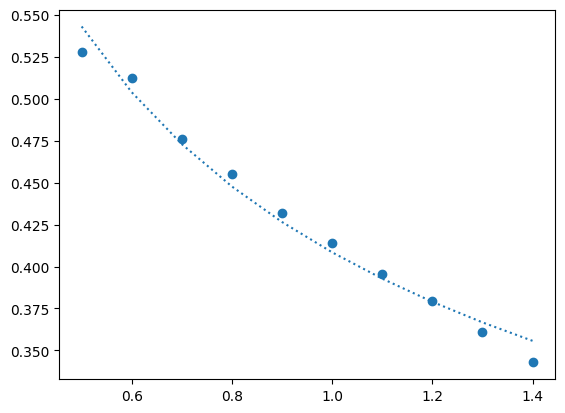

In [ ]:
plt.scatter(coeffs,fidelities)
plt.plot(coeffs,funcs,ls = ":")
plt.show()